In [1]:
import numpy as np
import pandas as pd
import arch as arch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
yen_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10902 entries, 1976-08-02 to 2019-10-15
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        10902 non-null  float64
 1   High                        10902 non-null  float64
 2   Low                         10902 non-null  float64
 3   Last                        10902 non-null  float64
 4   Change                      1415 non-null   float64
 5   Settle                      10902 non-null  float64
 6   Volume                      10902 non-null  float64
 7   Previous Day Open Interest  10902 non-null  float64
dtypes: float64(8)
memory usage: 766.5 KB


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

Text(0.5, 1.0, 'Yen Futures Settle Price')

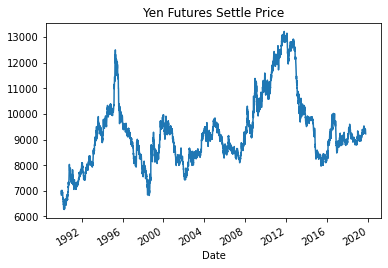

In [5]:
# Plot just the "Settle" column from the dataframe:
settle_plot = yen_futures.Settle.plot.line()
settle_plot.set_title('Yen Futures Settle Price')

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
ts_noise 

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
                ...    
2019-10-09    24.939247
2019-10-10    -5.868559
2019-10-11   -54.454594
2019-10-14   -36.423060
2019-10-15   -75.844123
Name: Settle_cycle, Length: 7515, dtype: float64

In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
trend_noise = pd.DataFrame({'Settle' : yen_futures.Settle, 'Noise' :ts_noise, 'Trend': ts_trend})
trend_noise.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


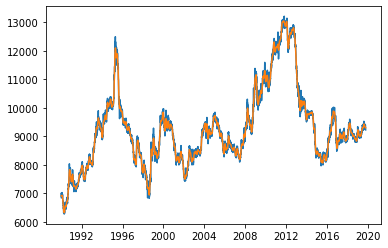

In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
import matplotlib.pyplot as plt

plt.plot(trend_noise.index, trend_noise.Settle, label='Settle')
plt.plot(trend_noise.index, trend_noise.Trend, label='Trend')
plt.show()





<AxesSubplot:xlabel='Date'>

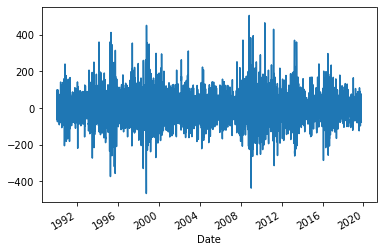

In [9]:
# Plot the Settle Noise
##decomp["Settle"].plot()
trend_noise.Noise.plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [11]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
from statsmodels.tsa.arima_model import ARMA 
model = sm.tsa.ARMA(returns.Settle.values, order = (2,1))

# Fit the model and assign it to a variable called results
result = model.fit()

In [12]:
# Output model summary results:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 15 May 2021   AIC                          15798.142
Time:                        08:58:15   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3061      1.277     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2945      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3367           +0.0000j            3.3367            0.5000
AR.2         -157.2756           +0.0000j          157.2756            0.5000
MA.1           -3.3957           +0.0000j            3.3957            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

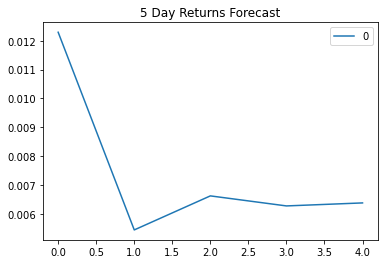

In [13]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(result.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast") 

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
p = 5
d = 1
q = 1

arima_model = ARIMA(yen_futures.Settle.values, order = (p,d,q))

# Fit the model
results = arima_model.fit();

In [15]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 15 May 2021   AIC                          83905.238
Time:                        09:00:29   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.y      0.2820      0.699      0.403      0.687      -1.089       1.653
ar.L2.D.y      0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2971      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8916           -1.3787j            2.3407           -0.1002
AR.2            1.8916           +1.3787j            2.3407            0.1002
AR.3           -2.2690           -3.0213j            3.7785           -0.3525
AR.4           -2.2690           +3.0213j            3.7785            0.3525
AR.5          -11.0358           -0.0000j           11.0358           -0.5000
MA.1            3.3664           +0.0000j            3.3664            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

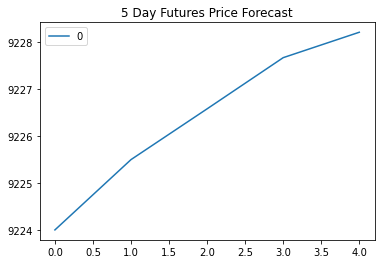

In [16]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [17]:
from arch import arch_model



In [18]:
# Estimate a GARCH model: ## look 10.2 07
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)
# Fit the model
res = model.fit(disp="off")



In [19]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Sat, May 15 2021   Df Residuals:                     7514
Time:                        09:00:32   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [20]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [21]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2009-12-31', horizon=forecast_horizon)
forecasts

In [22]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2009-12-31,12.285950,12.278888,12.271880,12.264927,12.258028
2010-01-04,12.183206,12.176943,12.170728,12.164562,12.158443
2010-01-05,12.275316,12.268336,12.261410,12.254539,12.247720
2010-01-06,12.234593,12.227929,12.221317,12.214756,12.208247
2010-01-07,12.236787,12.230106,12.223477,12.216900,12.210374


In [23]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2009-12-31,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2019-10-02,2019-10-03,2019-10-04,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-14,2019-10-15
h.1,12.285950,12.183206,12.275316,12.234593,12.236787,12.123070,12.020665,12.328359,12.172355,12.033256,...,7.601828,7.537698,7.434126,7.445491,7.363751,7.376183,7.367144,7.476215,7.389277,7.434026
h.2,12.278888,12.176943,12.268336,12.227929,12.230106,12.117277,12.015677,12.320969,12.166176,12.028169,...,7.641236,7.577972,7.475820,7.487028,7.406426,7.418683,7.409771,7.517329,7.431594,7.475721
h.3,12.271880,12.170728,12.261410,12.221317,12.223477,12.111529,12.010728,12.313636,12.160045,12.023122,...,7.680117,7.617701,7.516940,7.527994,7.448504,7.460591,7.451803,7.557880,7.473323,7.516842
h.4,12.264927,12.164562,12.254539,12.214756,12.216900,12.105826,12.005819,12.306360,12.153962,12.018115,...,7.718482,7.656897,7.557496,7.568400,7.490000,7.501920,7.493253,7.597881,7.514477,7.557400
h.5,12.258028,12.158443,12.247720,12.208247,12.210374,12.100167,12.000949,12.299140,12.147927,12.013147,...,7.756340,7.695569,7.597502,7.608258,7.530925,7.542682,7.534133,7.637342,7.555067,7.597407


In [ ]:
# Plot the final forecast
final.plot.line() 

<AxesSubplot:>

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

I would buy the yen later because from the forecast, the price is increasing. It would be better to get it while it is cheaper.

The risk of the yen is expected to increase from the forecast.

I do not feel confident using the model for trading. 
The ARIMA model has a significantly higher BIC and AIC than the other two. 
I would want to add other explanatory variables to test the validity, such as forward and current rates.